In [1]:
from openfermion.hamiltonians import MolecularData, load_molecular_hamiltonian
from openfermion.ops import FermionOperator
from openfermion.transforms import bravyi_kitaev
from openfermion.utils import hermitian_conjugated
from openfermion.ops import QubitOperator
from forestopenfermion import pyquilpauli_to_qubitop, qubitop_to_pyquilpauli
from pyquil.paulis import PauliSum
from pyquil.api import WavefunctionSimulator
from scipy.optimize import minimize
from pyquil import Program
from pyquil.gates import *

import numpy as np
import functools

import matplotlib.pyplot as plt
%matplotlib inline

from openfermion.utils import uccsd_generator
from forestopenfermion import exponentiate


In [2]:
sim = WavefunctionSimulator()
numQubit = 14
class Track:
    def __init__(self):
        self.cnt = 0
        
        
def solve_vqe_ucc_BeH2(hamiltonian: PauliSum, degree) -> float:
    # Construct a variational quantum eigensolver solution to find the lowest
    # eigenvalue of the given hamiltonian
    
    # degree 1: up to T_1
    # degree 2: up to T_2
    
    numParams = 0
    if degree == 1:
        numParams = 24
    elif degree == 2:
        numParams = 24+100
    params_init = np.random.rand(numParams)*0.5-0.25
    
    track = Track()

    def inc(t, xk):
        t.cnt += 1
    
    
    def ansatz_energy(params):
        p = None
        p = Program()
        
        # Reference state
        p += X(0)
        p += X(2)
        p += X(4)
        
        single_amp = []
        double_amp = []
        
        # occupied: 0,1,2,3,4,5 unoccupied: rest
        for i in range(4):
            single_amp.append([[2*i+4, 0], params[6*i]])
            single_amp.append([[2*i+5, 1], params[6*i+1]])
            single_amp.append([[2*i+4, 2], params[6*i+2]])
            single_amp.append([[2*i+5, 3], params[6*i+3]])
            single_amp.append([[2*i+4, 4], params[6*i+4]])
            single_amp.append([[2*i+5, 5], params[6*i+5]])            
        '''
        if degree == 2:
            for i in range(5):
                for j in range(5):
                    double_amp.append([[2*i+4, 0, 2*j+5, 1], params[25+(5*i+j)*4]])
                    double_amp.append([[2*i+4, 0, 2*j+5, 3], params[25+(5*i+j)*4+1]])
                    double_amp.append([[2*i+4, 2, 2*j+5, 1], params[25+(5*i+j)*4+2]])
                    double_amp.append([[2*i+4, 2, 2*j+5, 3], params[25+(5*i+j)*4+3]])
        '''
        ucc_gen = uccsd_generator(single_amp, double_amp)
        try:
            ucc_program = exponentiate(ucc_gen_qubitop/(-1j))
        except:
            ucc_program = I(0)
        p += ucc_program

        energy = sim.expectation(p, hamiltonian).real
        return energy

    params_answer = minimize(ansatz_energy, params_init, method='L-BFGS-B', callback=functools.partial(inc, track)).x
    return ansatz_energy(params_answer), track.cnt

In [3]:
def get_ground_energy_ucc_BeH2(interaction_hamil, degree):
    fermionop_hamil = FermionOperator()
    for key in interaction_hamil:
        value = interaction_hamil[key]
        fermionop_hamil += FermionOperator(term=key, coefficient=value)
        
    qubitop_hamil = bravyi_kitaev(fermionop_hamil)
    pauliop_hamil = qubitop_to_pyquilpauli(qubitop_hamil)
    
    sim = WavefunctionSimulator()
    return solve_vqe_ucc_BeH2(pauliop_hamil, degree)


In [6]:
basis = 'sto-3g'
multiplicity = 1  # 2S+1
charge = 0

import matplotlib.pyplot as plt
%matplotlib inline

bond_lengths = np.linspace(0.3, 2.5, 23)
vqe_ground_energies = []
vqe_iter_mean = []
vqe_iter_std = []

for degree in [1]:
    gelist = []
    iterlist = []
    for bond_length in bond_lengths:
        geometry = [('H', (0., 0., -bond_length)), ('Be', (0., 0., 0.)), ('H', (0., 0., bond_length))]
        description = str(round(bond_length, 2))
        BeH2_interaction_hamil = load_molecular_hamiltonian(geometry,
            basis,
            multiplicity,
            description,
            n_active_electrons=None,
            n_active_orbitals=None)

        ge, cnt = get_ground_energy_ucc_BeH2(BeH2_interaction_hamil, degree)
        print('bond length: ', round(bond_length, 2), ' ground state energy: ', ge, ' iteration: ', cnt)
        gelist.append(ge)
        iterlist.append(cnt)
        
    vqe_ground_energies.append(gelist)
    vqe_iter_mean.append(np.mean(iterlist))
    vqe_iter_std.append(np.std(iterlist))


bond length:  0.3  ground state energy:  -10.330012635826012  iteration:  0
bond length:  0.4  ground state energy:  -12.48573044457023  iteration:  0
bond length:  0.5  ground state energy:  -13.646140625180168  iteration:  0
bond length:  0.6  ground state energy:  -14.37007547904024  iteration:  0
bond length:  0.7  ground state energy:  -14.84143848678558  iteration:  0
bond length:  0.8  ground state energy:  -15.145999262786003  iteration:  0
bond length:  0.9  ground state energy:  -15.338455484870787  iteration:  0
bond length:  1.0  ground state energy:  -15.455667773521121  iteration:  0
bond length:  1.1  ground state energy:  -15.521999127616981  iteration:  0
bond length:  1.2  ground state energy:  -15.553586475809588  iteration:  0
bond length:  1.3  ground state energy:  -15.561278032298555  iteration:  0
bond length:  1.4  ground state energy:  -15.552459810270177  iteration:  0
bond length:  1.5  ground state energy:  -15.532213326876317  iteration:  0
bond length:  1

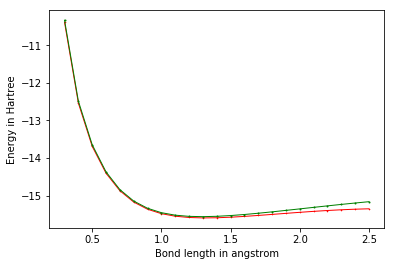

[array(-10.38746431), array(-12.53806991), array(-13.68996031), array(-14.40564902), -14.871329756203133, array(-15.17280541), array(-15.36415094), array(-15.48174107), array(-15.54963817), array(-15.58381205), array(-15.59504708), array(-15.59074335), array(-15.57605125), array(-15.55462369), array(-15.52912134), array(-15.50154509), array(-15.47345142), array(-15.44609374), array(-15.42051855), array(-15.39762993), array(-15.37821354), array(-15.36287431), array(-15.35183431)]


In [11]:
# Set molecule parameters.
basis = 'sto-3g'
multiplicity = 1

# Generate molecule at different bond lengths.
hf_energies = []
fci_energies = []
bond_lengths = []
for bond_length in np.linspace(0.3, 2.5, 23):
    bond_lengths += [bond_length]
    description = str(round(bond_length,2))
#    print(description)
    geometry = [('H', (0., 0., -bond_length)), ('Be', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    molecule = MolecularData(
        geometry, basis, multiplicity, description=description)
    
    # Load data.
    molecule.load()
    fci_energies += [molecule.fci_energy]

fci_energies[4] = -14.871329756203133    
plt.figure(0)
plt.plot(bond_lengths, fci_energies, 'rx-', linewidth=1, markersize=1)
plt.plot(bond_lengths, vqe_ground_energies[0], 'go-', linewidth=1, markersize=1)
plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.show()

print(fci_energies)